This notebook performs group level spectral analyses for changes in theta and SWR frequency during trace conditioning. Ideally it will visual each animal side-by-side along with a combined, averaged spectrogram for each task stage.

In [1]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path
import platform
from copy import deepcopy

# Comment here to add in for either mac or linux computer
if platform.system() == "Linux":   # for linux
    sys.path.extend(['/data/GitHub/NeuroPy']) 
    sys.path.extend(['/data/GitHub/TraceFC/'])
elif platform.system() == "Darwin":
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/TraceFC'])
elif platform.system() == "Windows":
    print('No windows repositories defined')

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.miniscopeio import MiniscopeIO
from neuropy.core import Epoch
from neuropy.utils import plot_util
from neuropy.utils.signal_process import WaveletSg
from neuropy.plotting.spikes import plot_raster, plot_binned_raster
from neuropy.plotting.signals import plot_signal_w_epochs, plot_spectrogram

from tracefc.io.session_directory import get_session_dir


# Load in data and set things up

In [2]:
# Define a class for a typical recording or set of recordings
from neuropy.core.session import ProcessData
    
def sess_use(basepath=os.getcwd()):

    return ProcessData(basepath)

In [3]:
# Load in / initialize sessions
import itertools
animals = ['Finn', 'Han', 'Rey', 'Rose', 'Django', 'Boba', 'Finn2']
sessions = ['habituation1']

sess_list = []
for sess_name, animal in itertools.product(sessions, animals):
    try:
        sess_dir = get_session_dir(animal, sess_name)
        sess_list.append(sess_use(sess_dir))
    except IndexError:
        print(f"{animal}_{sess_name} missing - skipped")
print(sess_list[0].recinfo)


filename: /data2/Trace_FC/Recording_Rats/Finn/2022_01_17_habituation1/Finn_habituation1_denoised.xml 
# channels: 35
sampling rate: 30000
lfp Srate (downsampled): 1250



In [4]:
# Set up for plotting and saving later
if "habituation" in sessions[0]:
    cs_names, cs_types = ['CS-'], ['csn']
elif "training" in sessions[0]:
    cs_names, cs_types = ['CS-', 'CS+'], ['csn', 'cs']
elif "recall" in sessions[0]:
    cs_names, cs_types = ['CS+', 'CS-', 'CS+'], ['cs', 'csn', 'cs2']

group_path = Path('/data2/Trace_FC/Recording_Rats')

In [5]:
params = {"theta": {"wv_range": np.arange(4, 14, 0.25), "freq_lims": (5, 12)}, 
             "ripple": {"wv_range": np.arange(125, 275, 5), "freq_lims": (140, 260)}}
cs_epoch_params = {"habituation1" : {"csn": 15, "cs": None, "cs2": None, "ITImax": 85}, 
                 "habituation2" : {"csn": 15, "cs": None, "cs2": None, "ITImax": 85},
                 "training" : {"csn": 5, "cs": 6, "cs2": None, "ITImax": 300},
                 "recall1" : {"csn": 12, "cs": 15, "cs2": 3, "ITImax": 85},
                 "recall1" : {"csn": 18, "cs": 15, "cs2": 3, "ITImax": 85},
                 "recall7" : {"csn": 12, "cs": 15, "cs2": 3, "ITImax": 85}}

In [6]:
# Load in relevant epochs

for sess in sess_list:
    # Artifact epochs
    art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")
    sess.art_epochs = Epoch(epochs=None, file=art_epochs_file)

    # CS epochs
    process_csn, process_cs, process_cs2 = True, True, True  # set flags for running code below
    if sess.basepath.name.find("habituation") >= 0:
        process_cs, process_cs2 = False, False
    elif sess.basepath.name.find('training') >= 0:
        process_cs2 = False
    sess.process_csn, sess.process_cs, sess.process_cs2 = process_csn, process_cs, process_cs2

    for cs_type in ('csn', 'cs', 'cs2'):
        if getattr(sess, f'process_{cs_type}'):
            cs_epochs_file = sess.filePrefix.with_suffix(f".{cs_type}_epochs.npy")
            setattr(sess, f"{cs_type}_epochs", Epoch(epochs=None, file=cs_epochs_file))

    # Ripple and theta epochs + channels
    ripple_file = sess.filePrefix.with_suffix(".ripple_epochs.npy")
    theta_file = sess.filePrefix.with_suffix(".theta_epochs.npy")
    sess.theta_epochs = Epoch(epochs=None, file=theta_file)
    sess.theta_channel = sess.theta_epochs.metadata["channels"][0]
    sess.ripple_epochs = Epoch(epochs=None, file=ripple_file)
    sess.ripple_channel = sess.ripple_epochs.metadata["channels"][0]

    # Add in info for each session for labeling plots later
    sess_info = str(sess.basepath).split("/")[-2:]
    sess.animal = sess_info[0]
    sess.sess_name = sess_info[1].split("_")[-1]


In [7]:
# # Add in info for each session for labeling plots later
# for sess in sess_list:
#     # save session info
#     sess_info = str(sess.basepath).split("/")[-2:]
#     sess.animal = sess_info[0]
#     sess.sess_name = sess_info[1].split("_")[-1]

# Define relevant functions for this notebook

In [8]:
def fill_in_nan_cs_epochs(cs_epochs, nepochs_expected, ITImax=85):
    """Fill in missing epochs with nans. Better is to do this during CS epoch sync!! Assumes first cs is never missing"""
    df_fix = deepcopy(cs_epochs._epochs)
    
    # Start by filling in any missing at the end.
    inds_add = np.where(np.diff(cs_epochs.starts) > ITImax)[0]
    if len(inds_add) > 0:
        cs_epochs.add_epoch_by_index(inds_add[0] + 0.5, np.nan, np.nan)
        if len(inds_add) > 1:  # Recursively add the first event only
            fill_in_nan_cs_epochs(cs_epochs, nepochs_expected, ITImax)
    
    # Finish by filling in end epochs that might be missing (recursively, again)
    nepochs = len(cs_epochs.starts)
    nepochs_diff = nepochs_expected - nepochs
    if nepochs_diff > 0:
        cs_epochs.add_epoch_by_index(nepochs - 0.5, np.nan, np.nan)
        if nepochs_diff > 1:
            fill_in_nan_cs_epochs(cs_epochs, nepochs_expected, ITImax)
            
    return cs_epochs

In [9]:
# # Test to make sure nothing happens to an intact session - uncomment if having issues
# epochs_test = deepcopy(sess_list[0].csn_epochs)
# print(epochs_test._epochs)
# print(fill_in_nan_cs_epochs(epochs_test, epochs_test._epochs.shape[0], ITImax=1000)._epochs)

In [10]:
# Test for missing epochs at end and other points - two in middle + two at end - uncomment if having issues
# epochs_test = deepcopy(sess_list[0].csn_epochs)
# epochs_test._epochs = epochs_test._epochs.drop(index=3)
# epochs_test._epochs = epochs_test._epochs.drop(index=5)
# epochs_test._epochs = epochs_test._epochs.drop(index=epochs_test._epochs.index.max())
# epochs_test._epochs = epochs_test._epochs.drop(index=epochs_test._epochs.index.max())
# print(epochs_test._epochs)
# print(fill_in_nan_cs_epochs(epochs_test, 12)._epochs)

In [11]:
def get_osc_spectrogram(osc_type, freq_bins=np.arange(4, 14, 0.25), buffer_sec=(5, 65), sigma=None):
    """Loops through and gets spectrograms for each animal/session - mean and trial-by-trial"""

    # Perform wavelet for each session and get peri-CS activity!
    for sess in sess_list:
        print(f"Running {osc_type} wavelet on {sess.filePrefix.name}")
        signal = sess.eegfile.get_signal()
    
        wv_use = WaveletSg(signal.time_slice(channel_id=getattr(sess, f"{osc_type}_channel"), t_stop=np.min((80*60, signal.t_stop))), 
                             freqs=freq_bins, sigma=sigma)
    
        # Get mean wavelet and trial-by-trial wavelet for each session!
        cs_dict = cs_epoch_params[sess.sess_name]
        nepochs_expected = (cs_dict["csn"], cs_dict["cs"], cs_dict["cs2"])
        for cs_type, nepochs_expect in zip(('csn', 'cs', 'cs2'), nepochs_expected):
            if getattr(sess, f'process_{cs_type}'):
                print(cs_type)
                
                # Fix missing cs epochs
                cs_epochs_fix = fill_in_nan_cs_epochs(getattr(sess, f"{cs_type}_epochs"), nepochs_expect, ITImax=cs_dict["ITImax"])
                setattr(sess, f"{cs_type}_epochs", cs_epochs_fix)
                cs_start_times = getattr(sess, f"{cs_type}_epochs").starts
    
                # Get mean wavelet
                wv_use_mean = wv_use.get_pe_mean_spec(cs_start_times, buffer_sec, ignore_epochs=sess.art_epochs)
                setattr(sess, f"wv_{osc_type}_mean_{cs_type}", wv_use_mean)
    
                # Get event-by-event wavelet
                wv_use_by_trial = wv_use.get_pe_spec(cs_start_times, buffer_sec, ignore_epochs=sess.art_epochs)
                setattr(sess, f"wv_{osc_type}_by_trial_{cs_type}", wv_use_by_trial)
        

In [12]:
from tracefc.plotting.signals import plot_cs_mean_wavelet

def plot_ind_animals(osc_type: str in ["theta", "ripple"], buffer_sec, freq_lims):
    """Plot mean spectrogram across all trials for each animal"""
    nsesh = len(sess_list)
    f_ind, ax = plt.subplots(nsesh*2, 3, figsize=(12, 2.5*nsesh), height_ratios=[1, 9]*nsesh, sharex=True, layout='tight')
    
    wv_mean_comb = []
    for ids, sess in enumerate(sess_list):
        wv_comb_sesh = []
        for idc, (cs_name, cs_type) in enumerate(zip(cs_names, cs_types)):
            cs_start_times = getattr(sess, f"{cs_type}_epochs").starts
            wv_mean_use = getattr(sess, f"wv_{osc_type}_mean_{cs_type}")
            wv_comb_sesh.append(wv_mean_use.traces)
            std_sxx = None if idc == 0 else std_sxx
            _, std_sxx = plot_cs_mean_wavelet(wv_mean_use, cs_start_times, cs_type=cs_name, buffer_sec=buffer_sec, 
                                              freq_lims=freq_lims, calc_mean=False, std_sxx=std_sxx, 
                                              ax=ax[range(ids*2, (ids+1)*2), idc])
            ax[ids*2, idc].set_title(f"{sess.animal}_{sess.sess_name}")
        wv_mean_comb.append(wv_comb_sesh)

    if len(sessions) > 1:
        f_ind.savefig(group_path / "group_plots" / "Spectral_Analysis" / f"Group_{osc_type}_ind_plots_{'_'.join(sessions)}.pdf")
    else:
        f_ind.savefig(group_path / "group_plots" / "Spectral_Analysis" / f"{sess_name.capitalize()}_{osc_type}_ind_mean_plots.pdf")        

    return wv_mean_comb

In [13]:
def plot_mean_spec(osc_type, wv_mean_comb, buffer_sec, freq_lims=(5, 12)):
    """Plot average spectrogram for CS type averaged across all animals"""
    
    f_comb, ax = plt.subplots(2, 3, height_ratios = [1, 9], sharex=True, figsize=(12, 3.5), layout='tight')
    comb_mean = np.array(wv_mean_comb).mean(axis=0)
    
    for idn, (cs_name, cs_type) in enumerate(zip(cs_names, cs_types)):
        if getattr(sess_list[0], f"process_{cs_type}"):
            wv_mean_use = deepcopy(getattr(sess, f"wv_{osc_type}_mean_{cs_type}"))
            wv_mean_use.traces = comb_mean[idn]
            cs_start_times = getattr(sess, f"{cs_type}_epochs").starts
            _, std_sxx = plot_cs_mean_wavelet(wv_mean_use, cs_start_times, cs_type=cs_name, buffer_sec=buffer_sec, 
                                                      freq_lims=freq_lims, calc_mean=False, std_sxx=None, ax=ax[:, idn])

    if len(sessions) > 1:
        f_comb.savefig(group_path / "group_plots" / "Spectral_Analysis" / f"Group_{osc_type}_mean_plots_{'_'.join(sessions)}.pdf")
    else:
        f_comb.savefig(group_path / "group_plots" / "Spectral_Analysis" / f"{sess_name.capitalize()}_{osc_type}_group_mean_plots.pdf")

In [14]:
from tracefc.plotting.signals import plot_cs_outside_axes

def plot_trial_by_trial(osc_type, buffer_sec, freq_lims, groupby: None or int = None):
    """Plot mean spectrogram for each trial averaged across all animals"""

    def groupedAvg(myArray, N=2):
        result = np.cumsum(myArray, 0)[N-1::N]/float(N)
        result[1:] = result[1:] - result[:-1]
        return result
    
    for cs_type, cs_name in zip(cs_types, cs_names):

        # Grab data
        wv_comb_list = [getattr(sess, f"wv_{osc_type}_by_trial_{cs_type}") for sess in sess_list]
        ntrials = np.array([w.shape[2] for w in wv_comb_list])
        if len(np.unique(ntrials)) == 1:
            wv_comb = np.moveaxis(np.stack(wv_comb_list, axis=3), 2, 0)
        else:  # Chop off last few trials for the few animals that got extra either through a mistake or on purpose
            ntrials_min = ntrials.min()
            excess_trial_inds = np.where(ntrials > ntrials_min)[0]
            print(f"Excess trials detected in sessions # {excess_trial_inds}. Trimming all sessions to {ntrials_min}")
            wv_comb_list_fix = [w[:, :, :ntrials_min] for w in wv_comb_list]
            wv_comb = np.moveaxis(np.stack(wv_comb_list_fix, axis=3), 2, 0)

        grp_append = ""
        if groupby is not None:
            wv_comb = groupedAvg(wv_comb, groupby)
            grp_append = f"_groupby{groupby}"
        
        # Set up plot
        ncs = np.sum(~np.isnan(getattr(sess, f"{cs_type}_epochs").starts)) if groupby is None else wv_comb.shape[0]
        nrows = np.ceil(ncs/3).astype(int)
        ydim = 1.5*nrows if nrows > 1 else 2.0
        fig, ax = plt.subplots(nrows, 3, figsize=(12, ydim), layout="tight", sharex=True)

        # Loop through and plot each trial
        for idc, (wv_mean, a) in enumerate(zip(np.nanmean(wv_comb, axis=3), ax.T.reshape(-1))):
            wv_use = deepcopy(getattr(sess_list[0], f"wv_{osc_type}_mean_{cs_type}"))
            wv_use.traces = wv_mean
            std_sxx = np.nanstd(wv_mean)
            plot_spectrogram(
                wv_use,
                time_lims=np.multiply(buffer_sec, (-1, 1)),
                freq_lims=freq_lims,
                ax=a,
                std_sxx=std_sxx,
                widget=False,
            )
            plot_cs_outside_axes(a, buffer_sec, cs_name[:3], box_width=10)
            if groupby is None:
                a.set_title(f"{cs_name} #{idc + 1}")
            else:
                a.set_title(f"{cs_name} #{groupby*idc + 1}-{groupby*idc + groupby}")
        fig.suptitle(f"{sess_name.capitalize()}: {cs_type} Trial-by-trial {osc_type.capitalize()}")
        
        if len(sessions) > 1:
            fig.savefig(group_path / "group_plots" / "Spectral_Analysis" / f"Group_{osc_type}_{cs_type}_trial-by-trial_{'_'.join(sessions)}{grp_append}.pdf")
        else:
            fig.savefig(group_path / "group_plots" / "Spectral_Analysis" / f"{sess_name.capitalize()}_{osc_type}_{cs_type}_trial-by-trial{grp_append}.pdf")

# Theta band spectogram group plots

In [15]:
# Get spectrograms
get_osc_spectrogram("theta", freq_bins=params['theta']['wv_range'], buffer_sec=(5, 65))

Running theta wavelet on Finn_habituation1_denoised
csn
34312 frames between 533.8 and 561.2 ignored (sent to nan)
7429 frames between 610.9 and 662.6 ignored (sent to nan)
771 frames between 866.4 and 867.1 ignored (sent to nan)
34312 frames between 533.8 and 561.2 ignored (sent to nan)
7429 frames between 610.9 and 662.6 ignored (sent to nan)
771 frames between 866.4 and 867.1 ignored (sent to nan)
Running theta wavelet on Han_habituation1
csn
2014 frames between 72.7 and 80.1 ignored (sent to nan)
8485 frames between 324.3 and 331.1 ignored (sent to nan)
3452 frames between 825.3 and 838.6 ignored (sent to nan)
2921 frames between 869.8 and 912.9 ignored (sent to nan)
2014 frames between 72.7 and 80.1 ignored (sent to nan)
8485 frames between 324.3 and 331.1 ignored (sent to nan)
3452 frames between 825.3 and 838.6 ignored (sent to nan)
2921 frames between 869.8 and 912.9 ignored (sent to nan)
Running theta wavelet on Rey_habituation1_denoised
csn
21671 frames between 895.1 and 912.

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

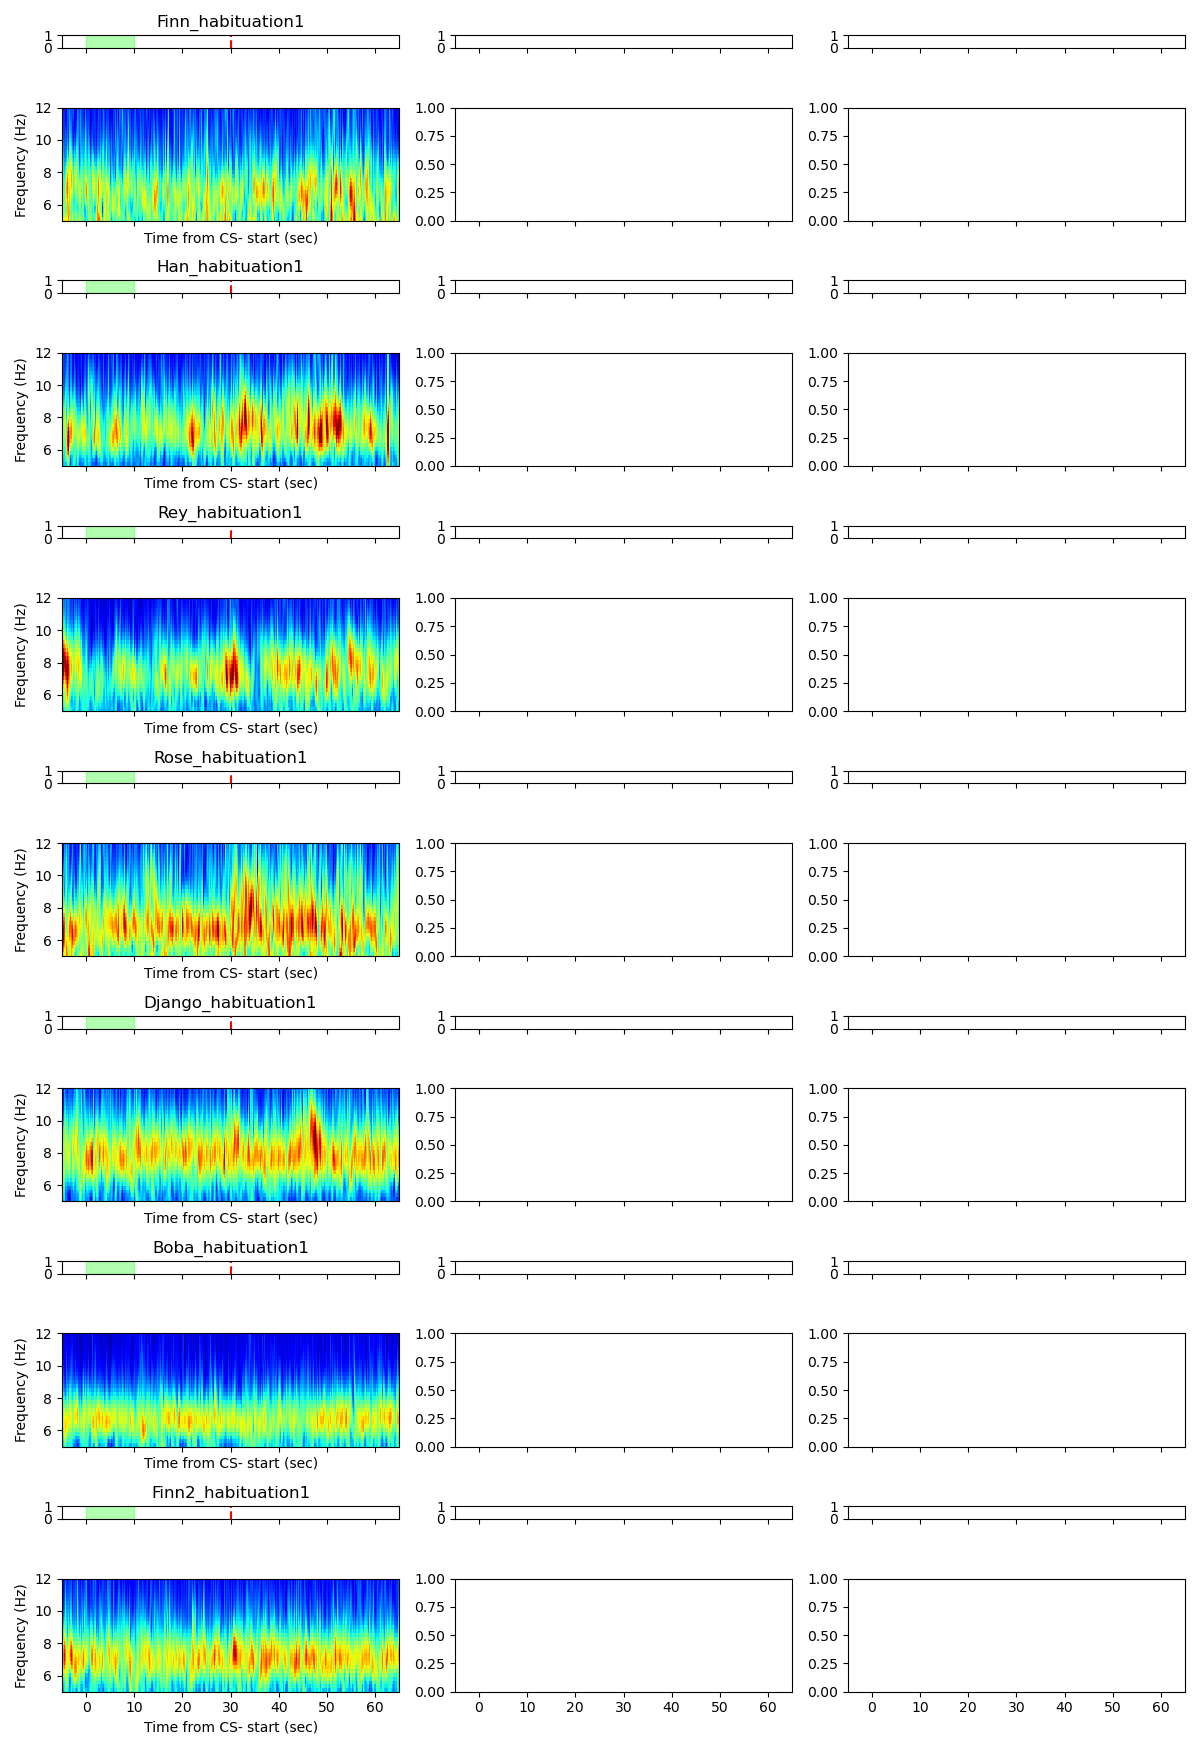

In [16]:
# Plot by animal
%matplotlib widget
theta_wv_comb = plot_ind_animals("theta", buffer_sec=(5, 65), freq_lims=params["theta"]["freq_lims"])

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

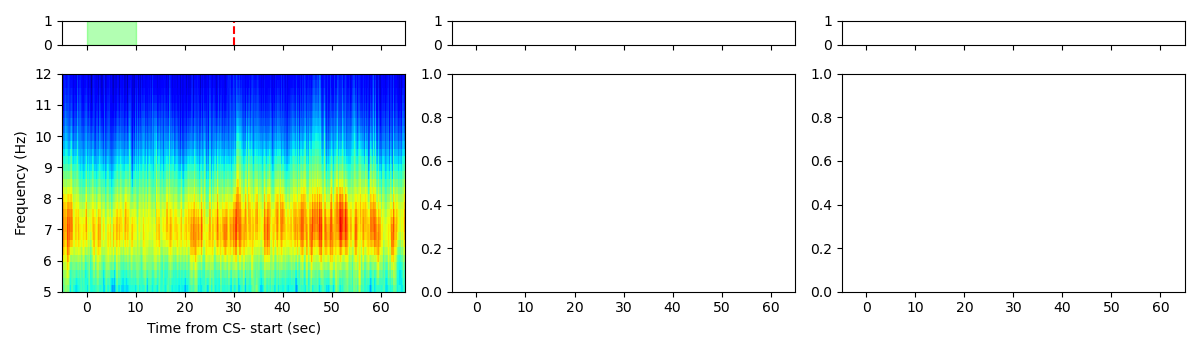

In [17]:
# Plot mean for each CS
plot_mean_spec("theta", theta_wv_comb, buffer_sec=(5, 65), freq_lims=params["theta"]["freq_lims"])

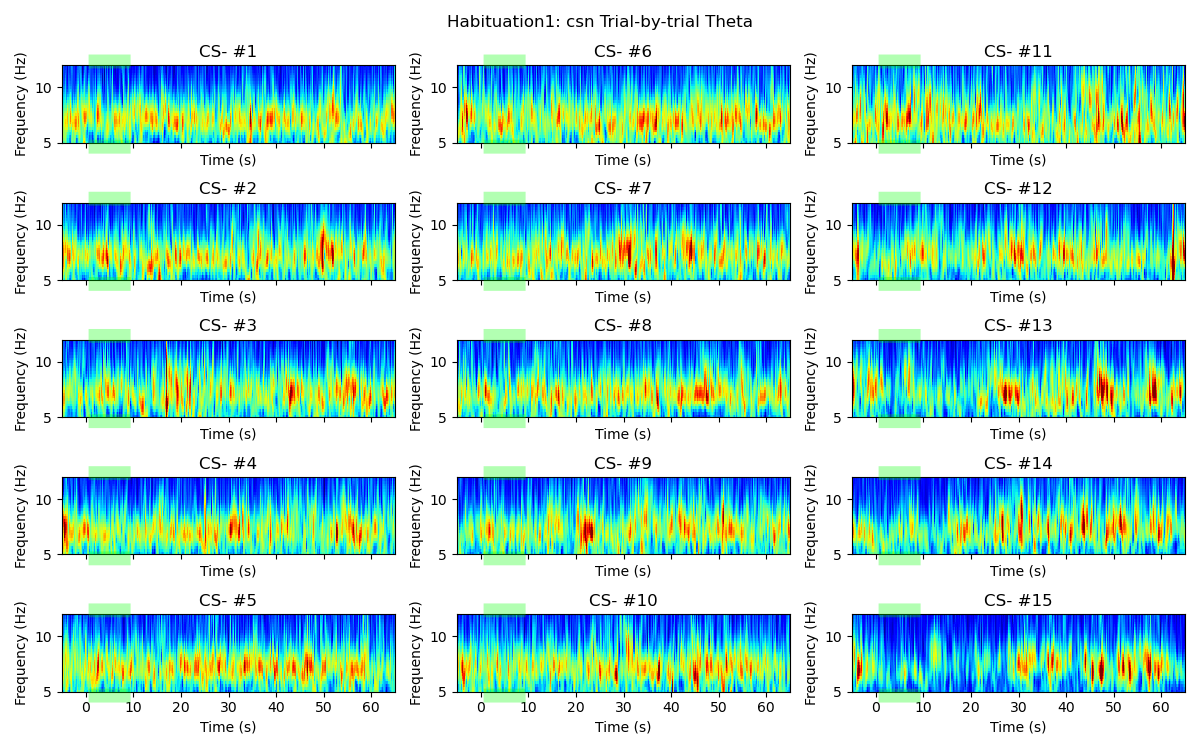

In [18]:
# Plot each CS by trial
plot_trial_by_trial("theta", buffer_sec=(5, 65), freq_lims=params["theta"]["freq_lims"])

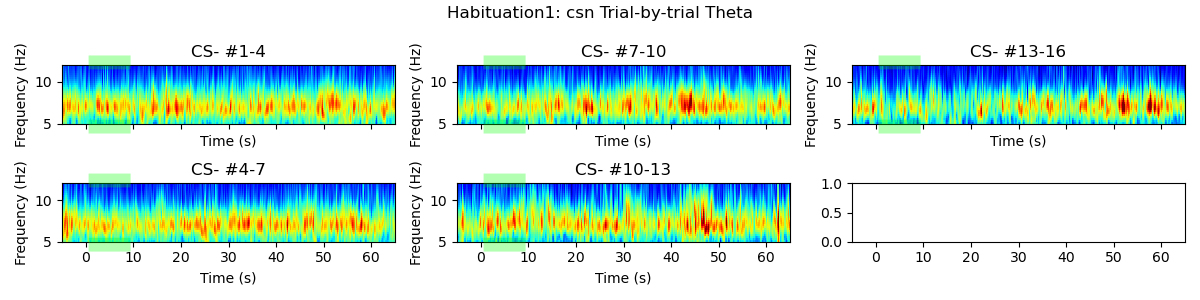

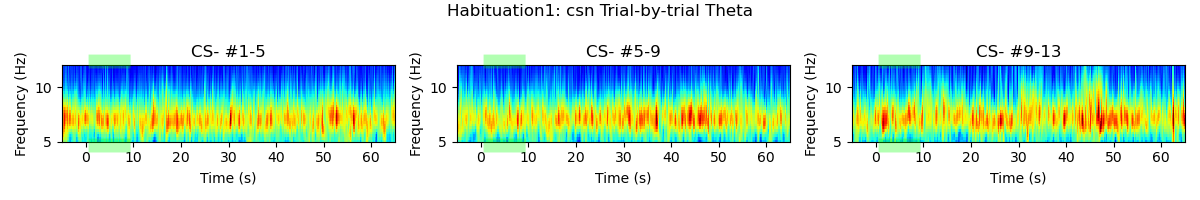

In [19]:
plot_trial_by_trial("theta", buffer_sec=(5, 65), freq_lims=params["theta"]["freq_lims"], groupby=3)
plot_trial_by_trial("theta", buffer_sec=(5, 65), freq_lims=params["theta"]["freq_lims"], groupby=4)

# Ripple-band spectrogram group plots

In [20]:
# Get spectrograms
sigma_use = 0.05
get_osc_spectrogram("ripple", freq_bins=params['ripple']['wv_range'], buffer_sec=(5, 65), sigma=sigma_use)

Running ripple wavelet on Finn_habituation1_denoised
csn
34312 frames between 533.8 and 561.2 ignored (sent to nan)
7429 frames between 610.9 and 662.6 ignored (sent to nan)
771 frames between 866.4 and 867.1 ignored (sent to nan)
34312 frames between 533.8 and 561.2 ignored (sent to nan)
7429 frames between 610.9 and 662.6 ignored (sent to nan)
771 frames between 866.4 and 867.1 ignored (sent to nan)
Running ripple wavelet on Han_habituation1
csn
2014 frames between 72.7 and 80.1 ignored (sent to nan)
8485 frames between 324.3 and 331.1 ignored (sent to nan)
3452 frames between 825.3 and 838.6 ignored (sent to nan)
2921 frames between 869.8 and 912.9 ignored (sent to nan)
2014 frames between 72.7 and 80.1 ignored (sent to nan)
8485 frames between 324.3 and 331.1 ignored (sent to nan)
3452 frames between 825.3 and 838.6 ignored (sent to nan)
2921 frames between 869.8 and 912.9 ignored (sent to nan)
Running ripple wavelet on Rey_habituation1_denoised
csn
21671 frames between 895.1 and 9

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

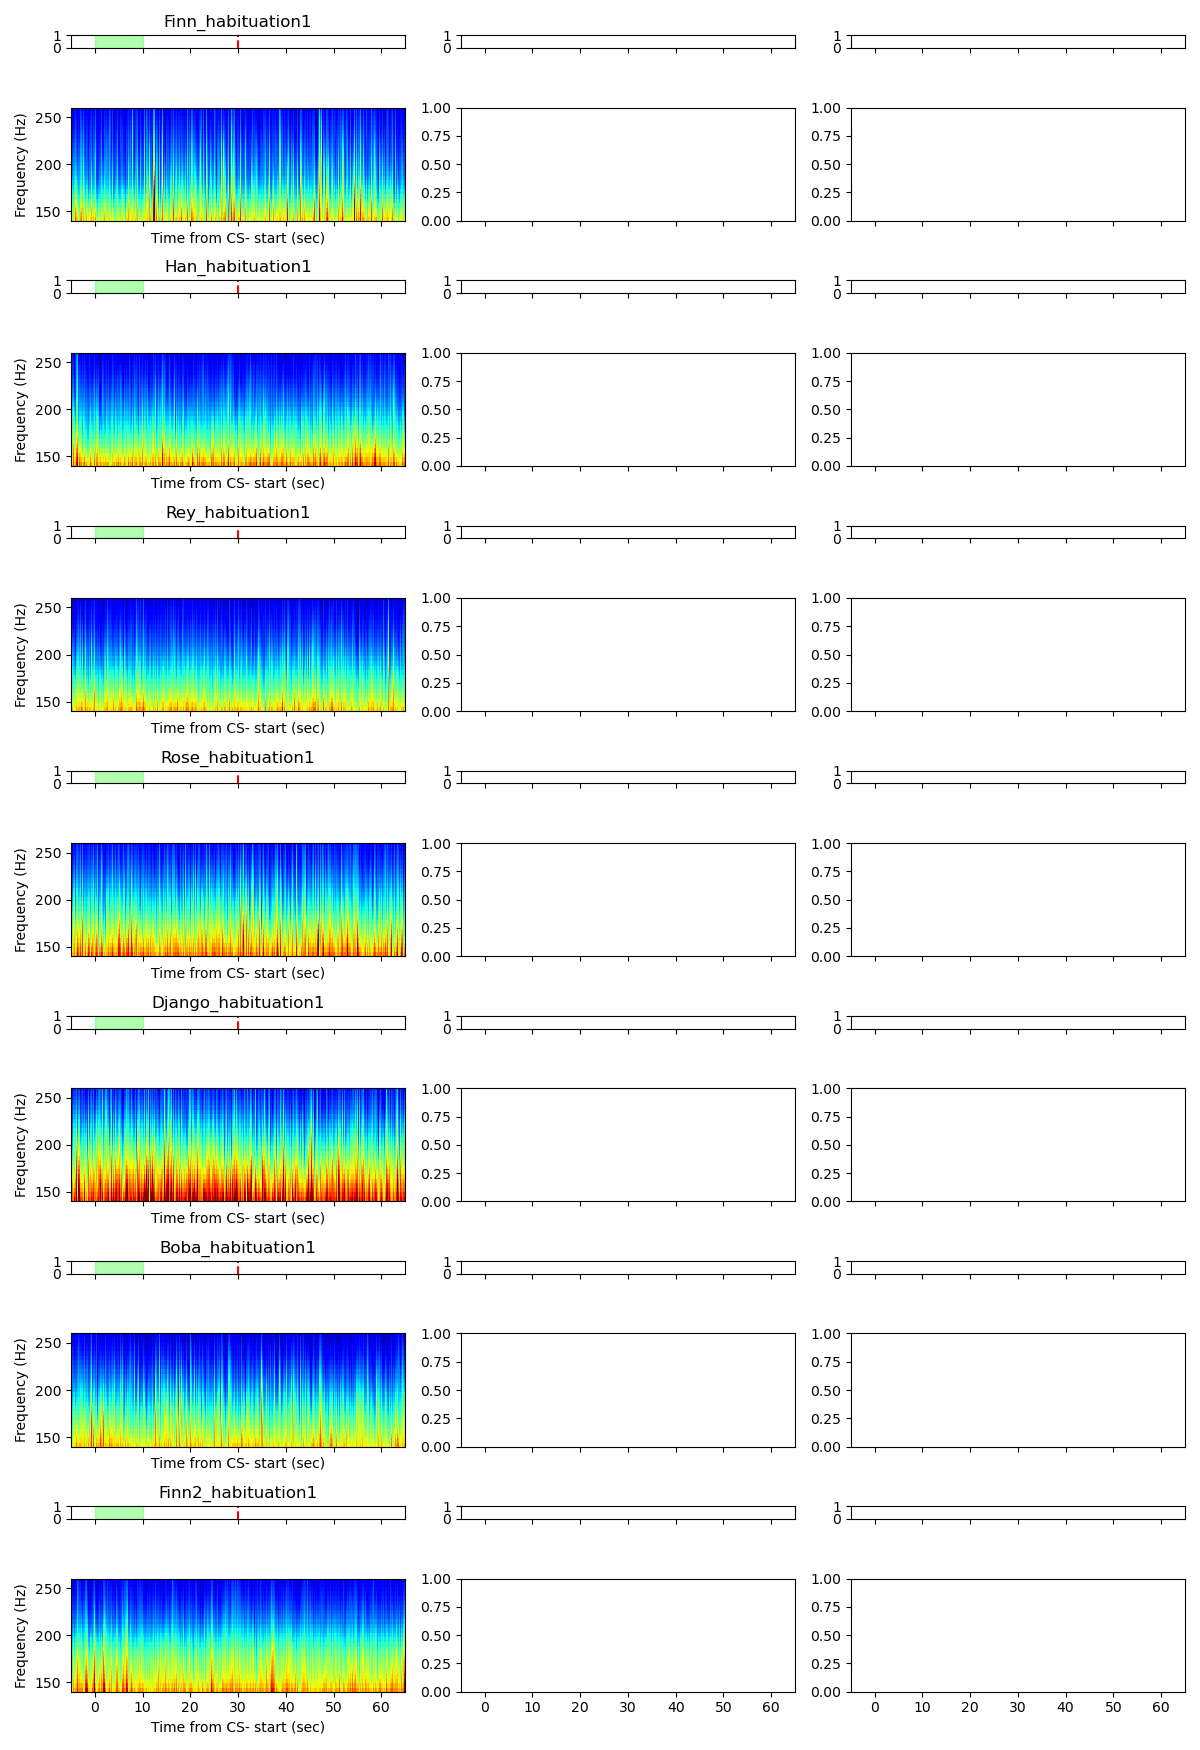

In [21]:
# Plot by animal
%matplotlib widget
ripple_wv_comb = plot_ind_animals("ripple", buffer_sec=(5, 65), freq_lims=params["ripple"]["freq_lims"])

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

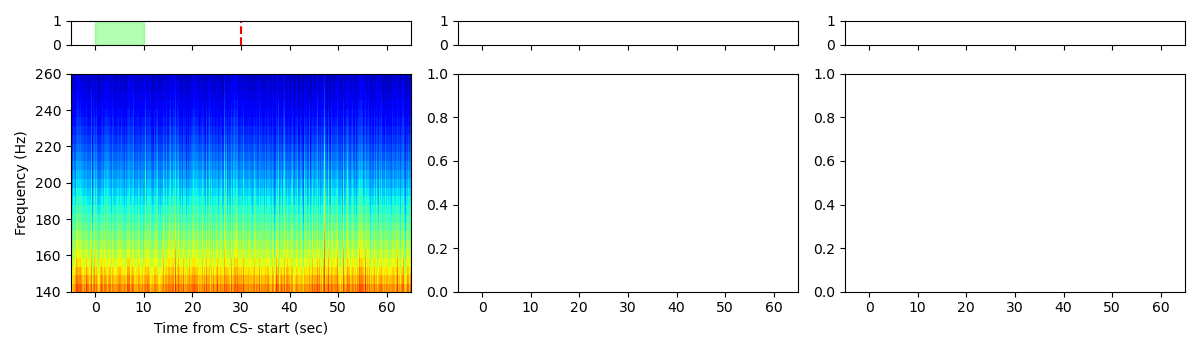

In [22]:
# Plot mean for each CS
plot_mean_spec("ripple", ripple_wv_comb, buffer_sec=(5, 65), freq_lims=params["ripple"]["freq_lims"])

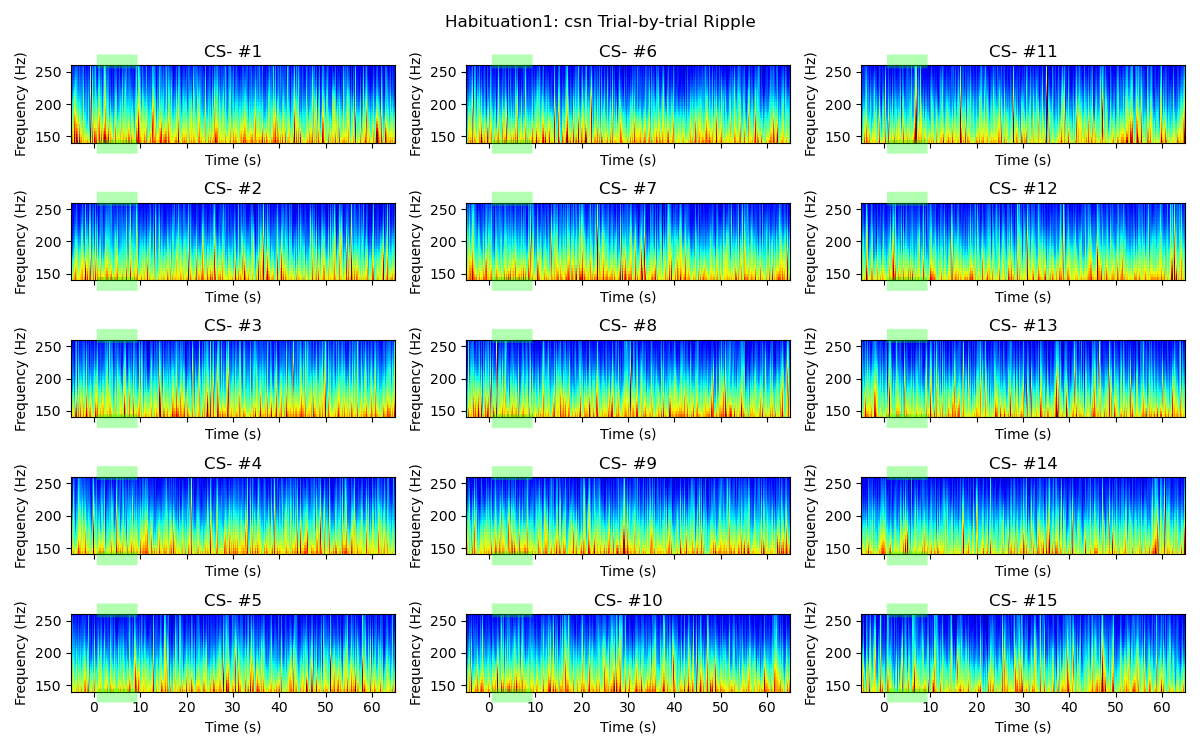

In [23]:
# Plot each CS by trial
plot_trial_by_trial("ripple", buffer_sec=(5, 65), freq_lims=params["ripple"]["freq_lims"])

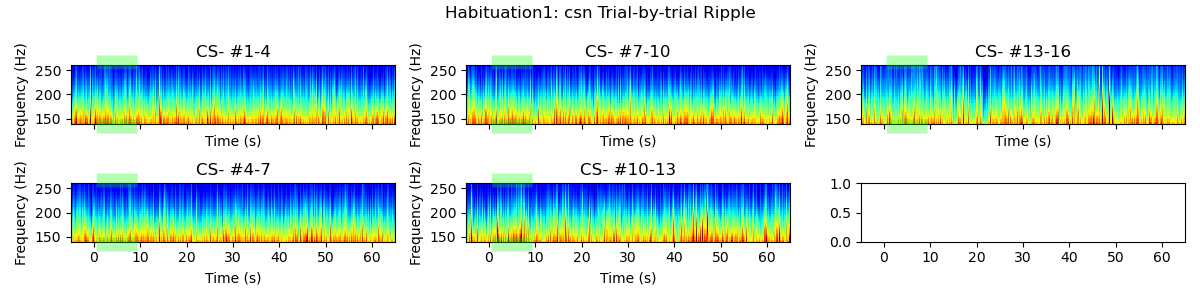

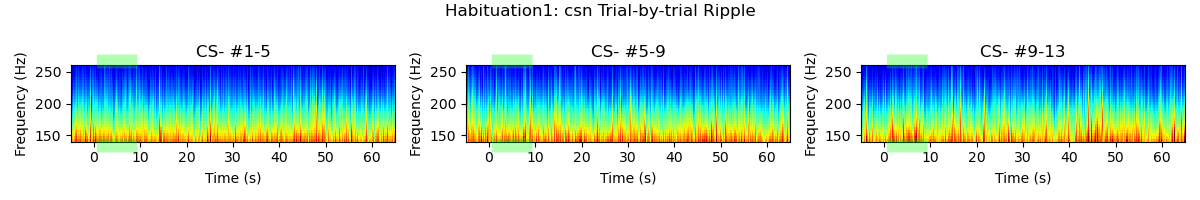

In [24]:
# Plot each CS by trial
plot_trial_by_trial("ripple", buffer_sec=(5, 65), freq_lims=params["ripple"]["freq_lims"], groupby=3)
plot_trial_by_trial("ripple", buffer_sec=(5, 65), freq_lims=params["ripple"]["freq_lims"], groupby=4)

# Old code before functions created preserved below for bug fixing

In [25]:
# # Perform theta wavelet for each session and get peri-CS activity!
# theta_range = np.arange(4, 14, 0.25)  # How do I select these? 0.25Hz seems good to start
# buffer_sec = (5, 65)
# for sess in sess_list:
#     print(f"Running theta wavelet on {sess.filePrefix.name}")
#     signal = sess.eegfile.get_signal()

#     wv_theta = WaveletSg(signal.time_slice(channel_id=sess.theta_channel, t_stop=np.min((80*60, signal.t_stop))), freqs=theta_range, sigma=None)

#     # Get mean wavelet and trial-by-trial wavelet for each session!
#     for cs_type, nepochs_expected in zip(('csn', 'cs', 'cs2'), (15, 12, 3)):
#         if getattr(sess, f'process_{cs_type}'):
#             print(cs_type)
            
#             # Fix missing cs epochs
#             cs_epochs_fix = fill_in_nan_cs_epochs(getattr(sess, f"{cs_type}_epochs"), nepochs_expected)
#             setattr(sess, f"{cs_type}_epochs", cs_epochs_fix)
#             cs_start_times = getattr(sess, f"{cs_type}_epochs").starts

#             # Get mean wavelet
#             wv_theta_mean = wv_theta.get_pe_mean_spec(cs_start_times, buffer_sec, ignore_epochs=sess.art_epochs)
#             setattr(sess, f"wv_theta_mean_{cs_type}", wv_theta_mean)

#             # Get event-by-event wavelet
#             wv_theta_by_trial = wv_theta.get_pe_spec(cs_start_times, buffer_sec, ignore_epochs=sess.art_epochs)
#             setattr(sess, f"wv_theta_by_trial_{cs_type}", wv_theta_by_trial)

In [26]:
# # Now try plotting!
# %matplotlib widget
# from tracefc.plotting.signals import plot_cs_mean_wavelet

# theta_freq_lims = (5, 12)
# nsesh = len(sess_list)
# ftheta_ind, ax = plt.subplots(nsesh*2, 3, figsize=(12, 2.5*nsesh), height_ratios=[1, 9]*nsesh, sharex=True, layout='tight')

# wv_mean_comb = []
# for ids, sess in enumerate(sess_list):
#     wv_comb_sesh = []
#     for idc, (cs_name, cs_type) in enumerate(zip(cs_names, cs_types)):
#         cs_start_times = getattr(sess, f"{cs_type}_epochs").starts
#         wv_mean_use = getattr(sess, f"wv_theta_mean_{cs_type}")
#         wv_comb_sesh.append(wv_mean_use.traces)
#         std_sxx = None if idc == 0 else std_sxx
#         _, std_sxx = plot_cs_mean_wavelet(wv_mean_use, cs_start_times, cs_type=cs_name, buffer_sec=buffer_sec, 
#                                           freq_lims=theta_freq_lims, calc_mean=False, std_sxx=std_sxx, 
#                                           ax=ax[range(ids*2, (ids+1)*2), idc])
#         ax[ids*2, idc].set_title(f"{sess.animal}_{sess.sess_name}")
#     wv_mean_comb.append(wv_comb_sesh)

# ftheta_ind.savefig(group_path / "group_plots" / "Spectral_Analysis" / f"Group_theta_ind_plots_{'_'.join(sessions)}.pdf")

In [27]:
# from copy import deepcopy
# ftheta_comb, ax = plt.subplots(2, 3, height_ratios = [1, 9], sharex=True, figsize=(12, 3.5), layout='tight')
# comb_mean = np.array(wv_mean_comb).mean(axis=0)

# for idn, (cs_name, cs_type) in enumerate(zip(cs_names, cs_types)):
#     if getattr(sess_list[0], f"process_{cs_type}"):
#         wv_mean_use = deepcopy(wv_mean_use)
#         wv_mean_use.traces = comb_mean[idn]
#         _, std_sxx = plot_cs_mean_wavelet(wv_mean_use, cs_start_times, cs_type=cs_name, buffer_sec=buffer_sec, 
#                                                   freq_lims=theta_freq_lims, calc_mean=False, std_sxx=None, ax=ax[:, idn])

# ftheta_comb.savefig(group_path / "group_plots" / "Spectral_Analysis" / f"Group_theta_mean_plots_{'_'.join(sessions)}.pdf")

In [28]:
# # Try plotting!
# from tracefc.plotting.signals import plot_cs_outside_axes
# for cs_type, cs_name in zip(cs_types, cs_names):
#     wv_comb = np.moveaxis(np.stack([getattr(sess, f"wv_theta_by_trial_{cs_type}") for sess in sess_list], axis=3), 2, 0)
#     ncs = np.sum(~np.isnan(getattr(sess, f"{cs_type}_epochs").starts))
#     nrows = np.ceil(ncs/3).astype(int)
#     ydim = 1.5*nrows if nrows > 1 else 2.0
#     fig, ax = plt.subplots(nrows, 3, figsize=(12, ydim), layout="tight", sharex=True)
#     for idc, (wv_mean, a) in enumerate(zip(np.nanmean(wv_comb, axis=3), ax.T.reshape(-1))):
#         wv_use = deepcopy(getattr(sess_list[0], f"wv_theta_mean_{cs_type}"))
#         wv_use.traces = wv_mean
#         std_sxx = np.nanstd(wv_mean)
#         plot_spectrogram(
#             wv_use,
#             time_lims=np.multiply(buffer_sec, (-1, 1)),
#             freq_lims=theta_freq_lims,
#             ax=a,
#             std_sxx=std_sxx,
#             widget=False,
#         )
#         plot_cs_outside_axes(a, buffer_sec, cs_name[:3], box_width=10)
#         a.set_title(f"{cs_name} #{idc + 1}")
#     fig.suptitle(f"{sess_name.capitalize()}: {cs_type} Trial-by-trial Theta")
#     fig.savefig(group_path / "group_plots" / "Spectral_Analysis" / f"{sess_name.capitalize()}_{cs_type}_theta_trial-by-trial.pdf")

In [29]:
# Perform theta wavelet for each session and get peri-CS activity!
# swr_range = np.arange(125, 275, 5)

# buffer_sec = (5, 65)
# for sess in sess_list:
#     print(f"Running swr wavelet on {sess.filePrefix.name}")
#     signal = sess.eegfile.get_signal()

#     wv_swr = WaveletSg(signal.time_slice(channel_id=sess.ripple_channel, t_stop=np.min((80*60, signal.t_stop))), freqs=swr_range, sigma=None)

#     # Get mean wavelet for each session!
#     for cs_type in ('csn', 'cs', 'cs2'):
#         if getattr(sess, f'process_{cs_type}'):
#             print(cs_type)

#             # Fix missing cs epochs
#             cs_epochs_fix = fill_in_nan_cs_epochs(getattr(sess, f"{cs_type}_epochs"), nepochs_expected)
#             setattr(sess, f"{cs_type}_epochs", cs_epochs_fix)
#             cs_start_times = getattr(sess, f"{cs_type}_epochs").starts

#             # Get mean wavelet
#             wv_swr_mean = wv_swr.get_pe_mean_spec(cs_start_times, buffer_sec, ignore_epochs=sess.art_epochs)
#             setattr(sess, f"wv_swr_mean_{cs_type}", wv_swr_mean)

#             # Get event-by-event wavelet
#             wv_swr_by_trial = wv_swr.get_pe_spec(cs_start_times, buffer_sec, ignore_epochs=sess.art_epochs)
#             setattr(sess, f"wv_swr_by_trial_{cs_type}", wv_swr_by_trial)

In [30]:
# # Now try plotting!
# %matplotlib widget
# from tracefc.plotting.signals import plot_cs_mean_wavelet

# ripple_freq_lims = (140, 260)
# nsesh = len(sess_list)
# fswr_ind, ax = plt.subplots(nsesh*2, 3, figsize=(12, 2.5*nsesh), height_ratios=[1, 9]*nsesh, sharex=True, layout='tight')

# wv_swr_mean_comb = []
# for ids, sess in enumerate(sess_list):
#     wv_comb_sesh = []
#     for idc, (cs_name, cs_type) in enumerate(zip(cs_names, cs_types)):
#         cs_start_times = getattr(sess, f"{cs_type}_epochs").starts
#         wv_mean_use = getattr(sess, f"wv_swr_mean_{cs_type}")
#         wv_comb_sesh.append(wv_mean_use.traces)
#         std_sxx = None if idc == 0 else std_sxx
#         _, std_sxx = plot_cs_mean_wavelet(wv_mean_use, cs_start_times, cs_type=cs_name, buffer_sec=buffer_sec, 
#                                           freq_lims=ripple_freq_lims, calc_mean=False, std_sxx=std_sxx, 
#                                           ax=ax[range(ids*2, (ids+1)*2), idc])
#         ax[ids*2, idc].set_title(f"{sess.animal}_{sess.sess_name}")
#     wv_swr_mean_comb.append(wv_comb_sesh)

# fswr_ind.savefig(group_path / "group_plots" / "Spectral_Analysis" / f"Group_SWR_ind_plots_{'_'.join(sessions)}.pdf")

In [31]:
# from copy import deepcopy
# fswr_comb, ax = plt.subplots(2, 3, height_ratios = [1, 9], sharex=True, figsize=(12, 3.5), layout='tight')
# comb_mean = np.array(wv_swr_mean_comb).mean(axis=0)

# for idn, (cs_name, cs_type) in enumerate(zip(cs_names, cs_types)):
#     if getattr(sess_list[0], f"process_{cs_type}"):
#         wv_mean_use = deepcopy(wv_mean_use)
#         wv_mean_use.traces = comb_mean[idn]
#         _, std_sxx = plot_cs_mean_wavelet(wv_mean_use, cs_start_times, cs_type=cs_name, buffer_sec=buffer_sec, 
#                                                   freq_lims=ripple_freq_lims, calc_mean=False, std_sxx=None, 
#                                                   ax=ax[:, idn])
# fswr_comb.savefig(group_path / "group_plots" / "Spectral_Analysis" / f"Group_SWR_mean_plots_{'_'.join(sessions)}.pdf")

In [32]:
# # Try plotting!
# from tracefc.plotting.signals import plot_cs_outside_axes
# for cs_type, cs_name in zip(cs_types, cs_names):
#     wv_comb = np.moveaxis(np.stack([getattr(sess, f"wv_swr_by_trial_{cs_type}") for sess in sess_list], axis=3), 2, 0)
#     ncs = np.sum(~np.isnan(getattr(sess, f"{cs_type}_epochs").starts))
#     nrows = np.ceil(ncs/3).astype(int)
#     ydim = 1.5*nrows if nrows > 1 else 2.0
#     fig, ax = plt.subplots(nrows, 3, figsize=(12, ydim), layout="tight", sharex=True)
#     for idc, (wv_mean, a) in enumerate(zip(np.nanmean(wv_comb, axis=3), ax.T.reshape(-1))):
#         wv_use = deepcopy(getattr(sess_list[0], f"wv_swr_mean_{cs_type}"))
#         wv_use.traces = wv_mean
#         std_sxx = np.nanstd(wv_mean)
#         plot_spectrogram(
#             wv_use,
#             time_lims=np.multiply(buffer_sec, (-1, 1)),
#             freq_lims=ripple_freq_lims,
#             ax=a,
#             std_sxx=std_sxx,
#             widget=False,
#         )
#         plot_cs_outside_axes(a, buffer_sec, cs_name[:3], box_width=10)
#         a.set_title(f"{cs_name} #{idc + 1}")
#     fig.suptitle(f"{sess_name.capitalize()}: {cs_name} Trial-by-trial SWR")
#     fig.savefig(group_path / "group_plots" / "Spectral_Analysis" / f"{sess_name.capitalize()}_{cs_type}_swr_trial-by-trial.pdf")

## Save notebook to working directory

In [33]:
from neuropy.utils.manipulate_files import save_notebook
save_notebook(group_path, save_append=f"_{'_'.join(sessions)}")

/data/GitHub/TraceFC/Notebooks/Spectral_Analysis_Group.ipynb saved to /data2/Trace_FC/Recording_Rats/Spectral_Analysis_Group_habituation1.ipynb
